# Mise en place du notebook

## Versionning

P6 v7 : avant split entre "P6 part1 v01" (contient la récupération des données et le SIFT) et "P6 part2 v01" (contient VGG-16).  
P6 part v01 : contient récupération des données et vectorisation par SIFT.

## Import des modules

In [485]:
# imports pour le développement
from pympler import asizeof
import mesfonctions
from importlib import reload
mesfonctions = reload(mesfonctions)

# imports pour la production
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from sklearn import decomposition
from sklearn import cluster, manifold, decomposition, preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from mesfonctions import display_scree_plot, display_factorial_planes
import pickle
from termcolor import colored, cprint
import cv2
from yellowbrick.cluster import KElbowVisualizer
import random
from collections import Counter
from cycler import cycler

## Fonctions courantes

In [187]:
def nom_fichier_photo(index, df=None):
    """Retourne le chemin + nom du fichier jpg d'une ligne de dataframe.
    Args : 
    - index : index de la ligne de df.
    Returns :
    - string.
    """
    if df is None:
        df = df_source
    return PATH + df['image'][index]

In [188]:
def print_df_line(index, image_only=False, df=None):
    """Imprime une ligne du dataframe df_source avec un formatage amélioré et une photo de l'objet.
    Args : 
    - index : index de la ligne de df_source.
    Returns :
    - void.
    """
    if df is None:
        df = df_source
        
    # Affichage ligne du dataframe
    if image_only == False:
        print(colored("NOM VARIABLE".center(30, ' '), 'blue', attrs=[
              'bold']), "     ", colored("VALEUR", 'blue', attrs=['bold']))
        for i in range(len(df_source.iloc[0])):
            print(colored(df_source.iloc[index].index[i].center(
                30, ' '), 'red'), "     ", df_source.iloc[index][i])
    # Affichage photo
    filename = PATH + df_source['image'][index]
    image = imread(filename)
    plt.style.use('default')
    plt.imshow(image)
    plt.show()

## Constantes

In [6]:
PATH = "Images_Flipkart/"

## Gestion des paramètres d'affichage de Jupyter

In [7]:
from IPython.core.display import HTML
plt.style.use('seaborn')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

# Notes

# Récupération des données

## df_source

In [8]:
df_source = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv',
                           sep=',',
                           low_memory=False)

In [9]:
df_source

uniq_id                           crawl_timestamp             \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

     product_url                                         \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

     product_name                                        \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

     product_category_tree                              pid                \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price image                                  \
0     1899.0         899.0            55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1      600.0         449.0            7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        NaN           NaN            64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     2699.0        1299.0            d4684dcdc759dd9cdf41504698d737d8.jpg   
4     2599.0         698.0            6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045  1399.0         999.0            958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  4930.0        1896.0            fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  4500.0        1449.0            5912e037d12774bb73a2048f35a00009.jpg   
1048  3465.0        1333.0            c3edc504d1b4f0b

         NOM VARIABLE                VALEUR
           uniq_id                   64d5d4a258243731dc7bbb1eef49ad74
       crawl_timestamp               2016-04-30 03:22:56 +0000
         product_url                 http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y
         product_name                Eurospa Cotton Terry Face Towel Set
    product_category_tree            ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]
             pid                     BTWEG6SHXTDB2A2Y
         retail_price                nan
       discounted_price              nan
            image                    64d5d4a258243731dc7bbb1eef49ad74.jpg
   is_FK_Advantage_product           False
         description                 Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET,

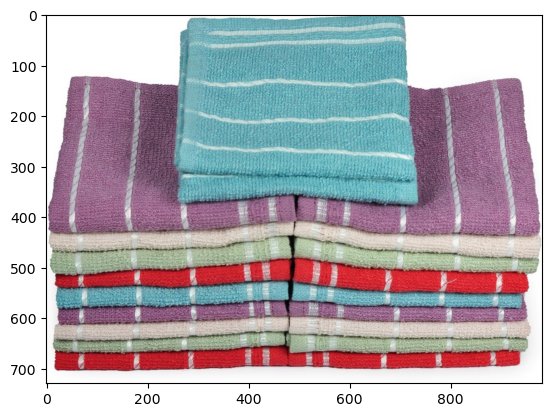

In [301]:
print_df_line(2)

## Extraction des labels de classification

In [298]:
ser_category = df_source['product_category_tree']
ser_category#.sample(20)

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [249]:
def counter_products_per_category(category):
    """
    Args :
    - category : string avec le début du nom de la catégorie.
    Returns :
    - nb de produits dans la catégorie.
    """
    st = '[\"' + category
    coun = Counter([st in ser_category[i] for i in ser_category.index]) 
    print(f"Nb de produits dans la catégorie \"{category}\" :", coun[1])

In [274]:
counter_products_per_category('Baby Care')
counter_products_per_category('Baby Care >> Infant Wear')
print("---")
counter_products_per_category('Kitchen & Dining')
counter_products_per_category('Kitchen & Dining >> Coffee Mugs')
counter_products_per_category('Kitchen & Dining >> Kitchen Tools')
print("---")
counter_products_per_category('Home Decor')
counter_products_per_category('Home Decor & Festive Needs >> Showpieces')
print("---")
counter_products_per_category('Home Furnishing')
counter_products_per_category('Home Furnishing >> Bed Linen')
counter_products_per_category('Home Furnishing >> Living')
print("---")
counter_products_per_category('Watches')
counter_products_per_category('Watches >> Wrist Watches')
print("---")
counter_products_per_category('Computers')
counter_products_per_category('Computers >> Laptop Accessories')
counter_products_per_category('Computers >> Network Components')
print("---")
counter_products_per_category('Beauty and Personal Care')
counter_products_per_category('Beauty and Personal Care >> Fragrances')

Nb de produits dans la catégorie "Baby Care" : 150
Nb de produits dans la catégorie "Baby Care >> Infant Wear" : 84
---
Nb de produits dans la catégorie "Kitchen & Dining" : 150
Nb de produits dans la catégorie "Kitchen & Dining >> Coffee Mugs" : 74
Nb de produits dans la catégorie "Kitchen & Dining >> Kitchen Tools" : 14
---
Nb de produits dans la catégorie "Home Decor" : 150
Nb de produits dans la catégorie "Home Decor & Festive Needs >> Showpieces" : 71
---
Nb de produits dans la catégorie "Home Furnishing" : 150
Nb de produits dans la catégorie "Home Furnishing >> Bed Linen" : 65
Nb de produits dans la catégorie "Home Furnishing >> Living" : 9
---
Nb de produits dans la catégorie "Watches" : 150
Nb de produits dans la catégorie "Watches >> Wrist Watches" : 149
---
Nb de produits dans la catégorie "Computers" : 150
Nb de produits dans la catégorie "Computers >> Laptop Accessories" : 87
Nb de produits dans la catégorie "Computers >> Network Components" : 49
---
Nb de produits dans la

## Ajout de la colonne 'label' dans df_source

In [275]:
labels = ["Beauty and Personal Care", "Computers", "Baby Care", "Home Decor", "Home Furnishing", "Kitchen & Dining", "Watches"]

In [293]:
def labelling(st):
    for lab in labels:
        if '[\"' + lab in st:
            return lab
            break
    return 'labelling error'

# test unitaire
st = df_source['product_category_tree'][3]
labelling(st)

'Home Furnishing'

In [300]:
df_source['label'] = df_source['product_category_tree'].copy().map(labelling)
df_source

uniq_id                           crawl_timestamp             \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

     product_url                                         \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

     product_name                                        \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

     product_category_tree                              pid                \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price image                                  \
0     1899.0         899.0            55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1      600.0         449.0            7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        NaN           NaN            64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     2699.0        1299.0            d4684dcdc759dd9cdf41504698d737d8.jpg   
4     2599.0         698.0            6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045  1399.0         999.0            958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  4930.0        1896.0            fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  4500.0        1449.0            5912e037d12774bb73a2048f35a00009.jpg   
1048  3465.0        1333.0            c3edc504d1b4f0b

## Sauvegarde de df_source (pickle)

In [383]:
pickle.dump(df_source, open('df_source.pkl', 'wb'))

# SIFT

On déroule la méthodologie décrite dans le webinaire OpenClassrooms sur SIFT.

## Descripteurs d'une image

In [424]:
def descripteurs_sift(index, plot=True, dimension=True):
    """Retourne le descripteur SIFT d'une photo.
    Args : 
    - index : index de la ligne de df_source.
    - plot : booléen pour tracer ou non la photo avec ses descripteurs.
    - dimension : booléen pour imprimer la dimension des descripteurs.
    Returns :
    - array numpy (descripteur SIFT) de 128 colonnes et "descripteurs" lignes.
    """
    image = cv2.imread(PATH + df_source['image'][index], 0)  # convert in grey
    image = cv2.equalizeHist(image)  # equalize image histogram
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    if plot:
        plt.style.use('default')
        plt.figure(figsize=(40, 40), edgecolor='black', linewidth=4)
        img = cv2.drawKeypoints(image, kp, image)
        plt.imshow(img)
        plt.show()
    if dimension:
        print("Dimension descripteurs : ", des.shape)
    return des

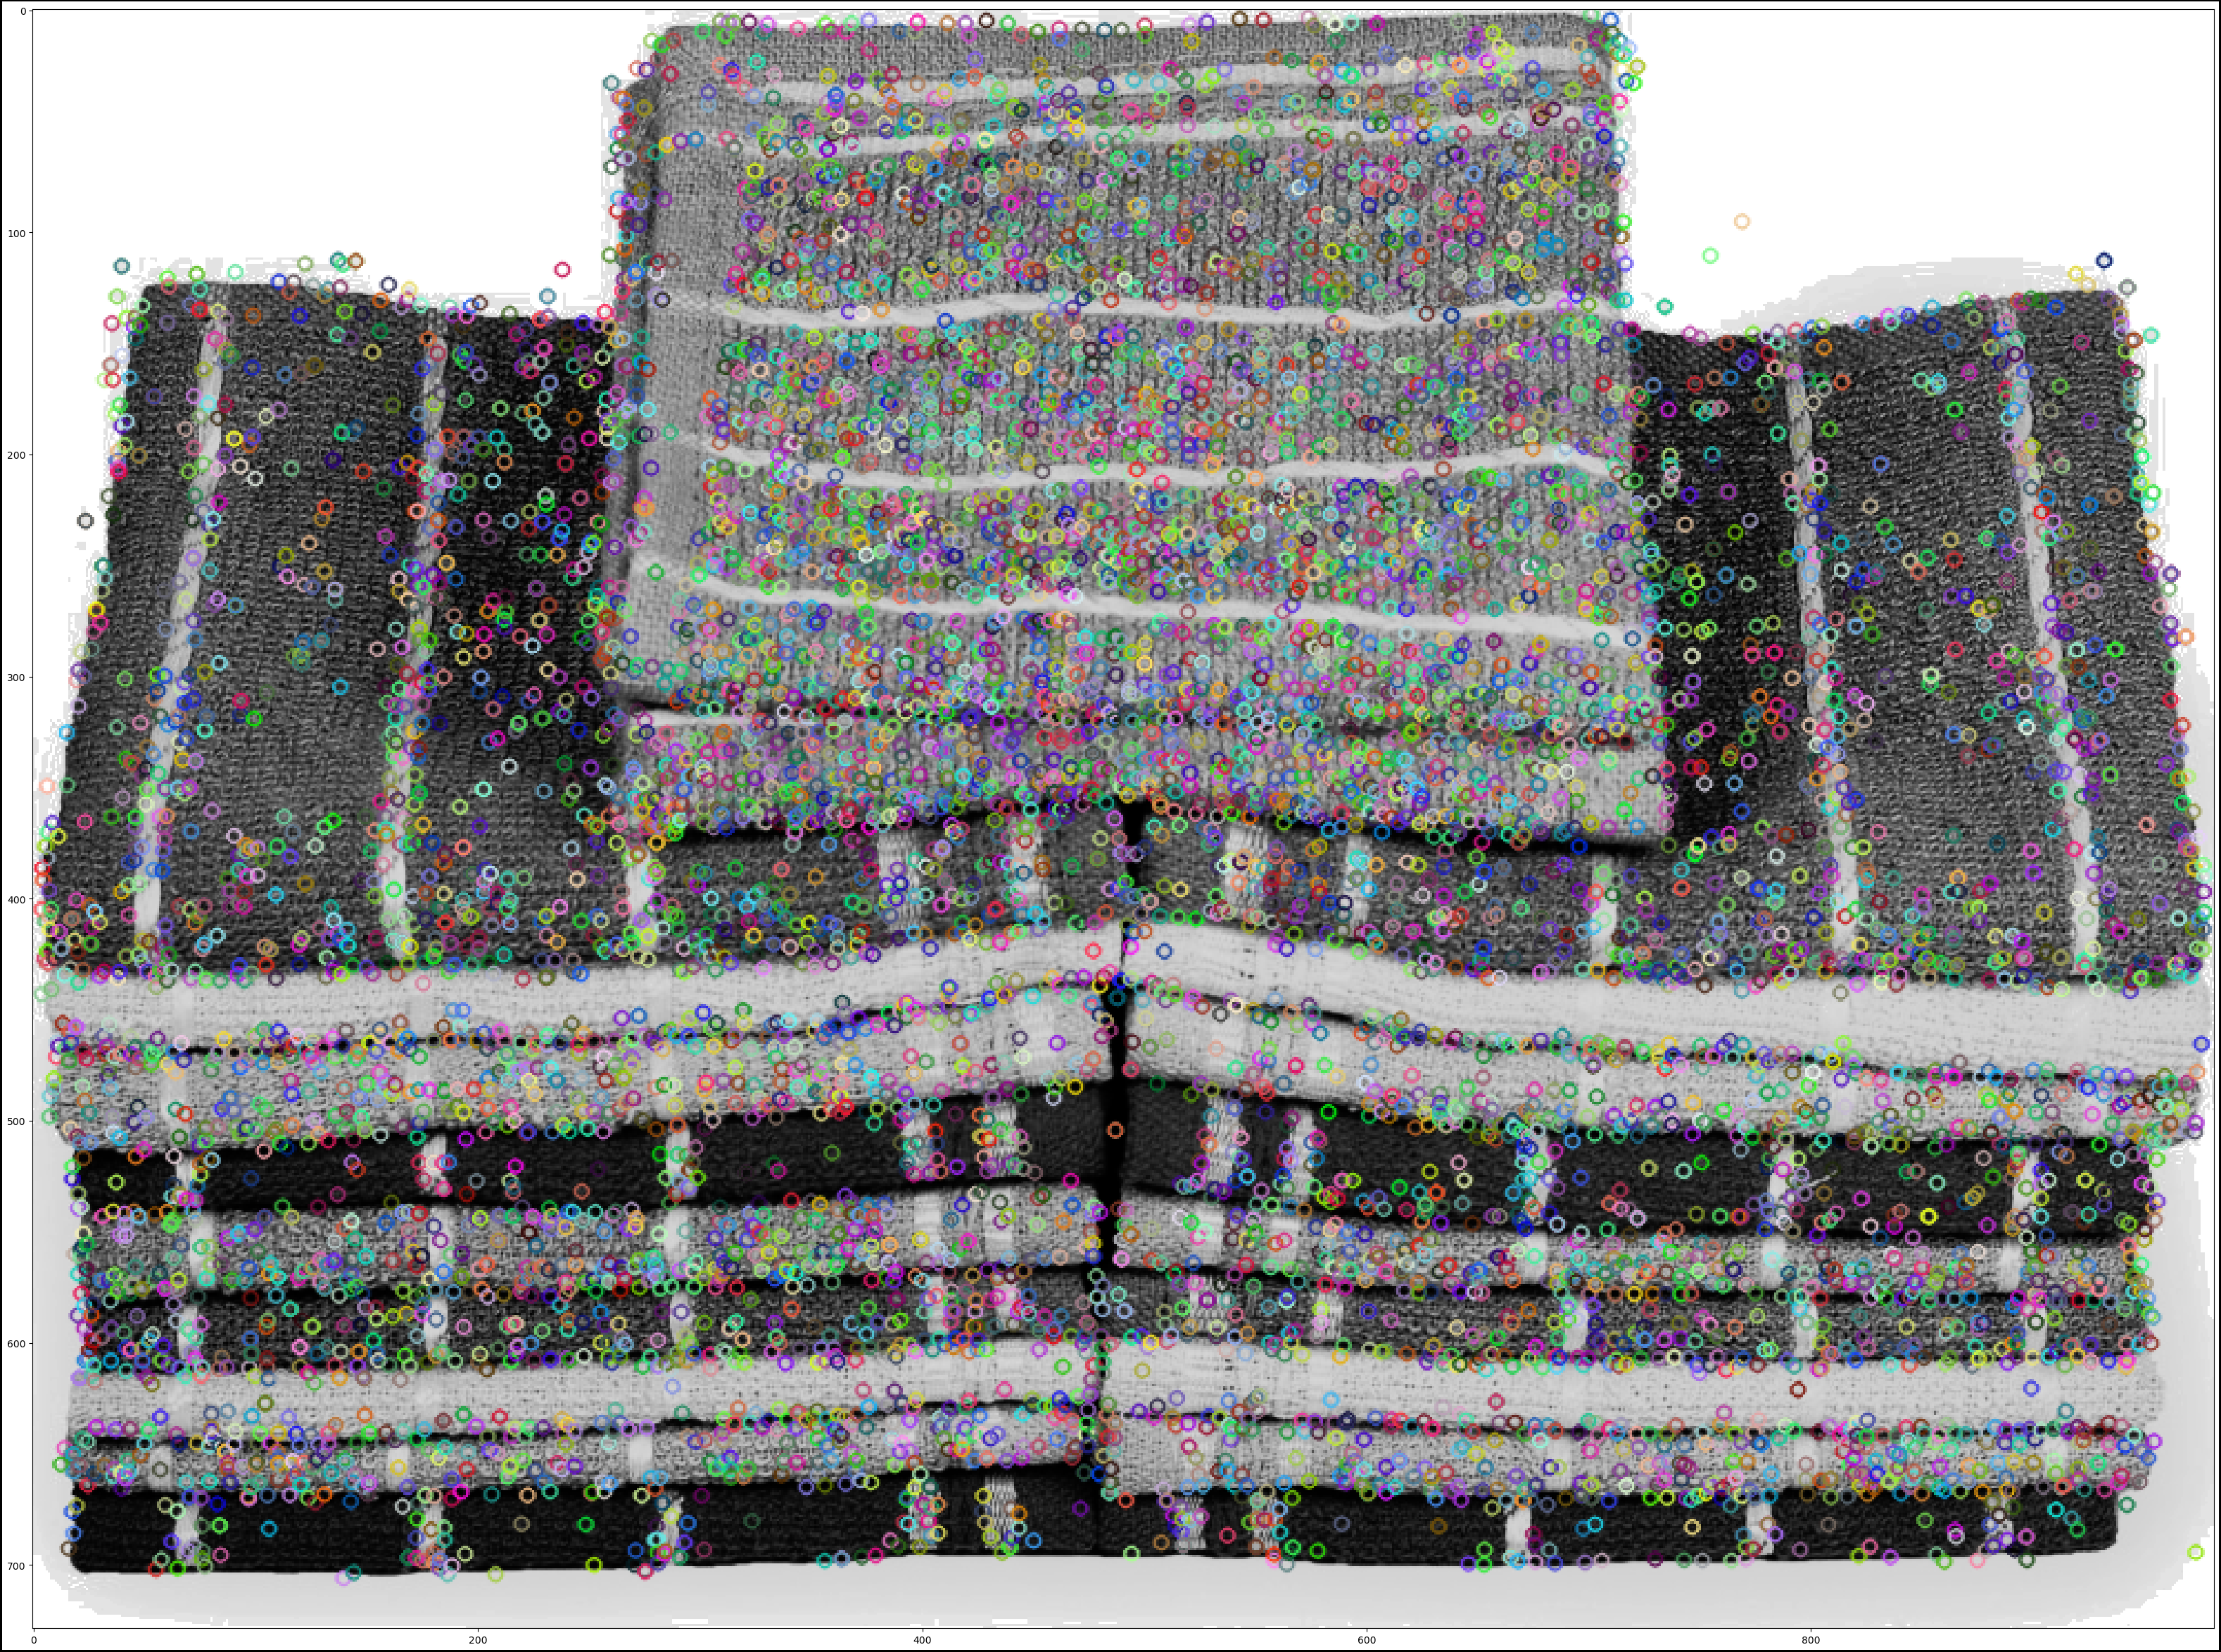

Dimension descripteurs :  (8896, 128)


array([[117.,  56.,   1., ...,   1.,   2.,   0.],
       [ 30.,   2.,  15., ...,   1.,   2.,   1.],
       [ 14.,  19.,   9., ...,   1.,   1.,   1.],
       ...,
       [ 57., 127.,   9., ...,   1.,   1.,   4.],
       [ 16.,   7.,   6., ...,   0.,   0.,   0.],
       [ 26.,   8.,  11., ...,   0.,   0.,   0.]], dtype=float32)

In [361]:
# test unitaire
descripteurs_sift(2)

## Créations des descripteurs de chaque image (990000 descripteurs, ~1000 par image)
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [60]:
# identification of key points and associated descriptors
sift_keypoints = []
sift = cv2.SIFT_create(nfeatures=1000)   # on se limite à 1000, sur ce dataset, il est fréquent de récupérer des descripteurs à 100000 lignes

for index in range(len(df_source)) :
    if index%10 == 0 : print(index, "", end='')
    image = cv2.imread(nom_fichier_photo(index),0) # ouverture fichier image et conversion en niveaux de gris
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 
Nombre de descripteurs :  (989655, 128)


In [61]:
# Sauvegarde des descripteurs calculés (pickle)
pickle.dump(sift_keypoints, open('sift_keypoints.pkl', 'wb'))

In [19]:
# Chargement des descripteurs calculés (pickle)
sift_keypoints = pickle.load(open('sift_keypoints.pkl', 'rb'))
len(sift_keypoints)

In [463]:
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)


Nombre de descripteurs :  (989655, 128)


## Utilisation de 995 clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [362]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters : ", k)

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

Nombre de clusters :  995


MiniBatchKMeans(init_size=2985, n_clusters=995, random_state=0)

### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [365]:
def build_histogram(kmeans, image_desc, image_num):
    """
    Construction d'un histogramme des centroïdes (en abscisse) pour chaque descripteur (cumulés en ordonnée).
    Args :
    - kmeans : modèle kmeans entrainé.
    - image_desc : liste des descripteur de chaque image.
    - image_num : index de l'image.
    Returns :
    - array numpy 1D de taille "nb de clusters".
    """
    res = kmeans.predict(image_desc)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(image_desc)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i, "", end='')
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # hist is the feature vector

im_features = np.asarray(hist_vectors)

0 100 200 300 400 500 600 700 800 900 1000 

### Affichage d'histogramme

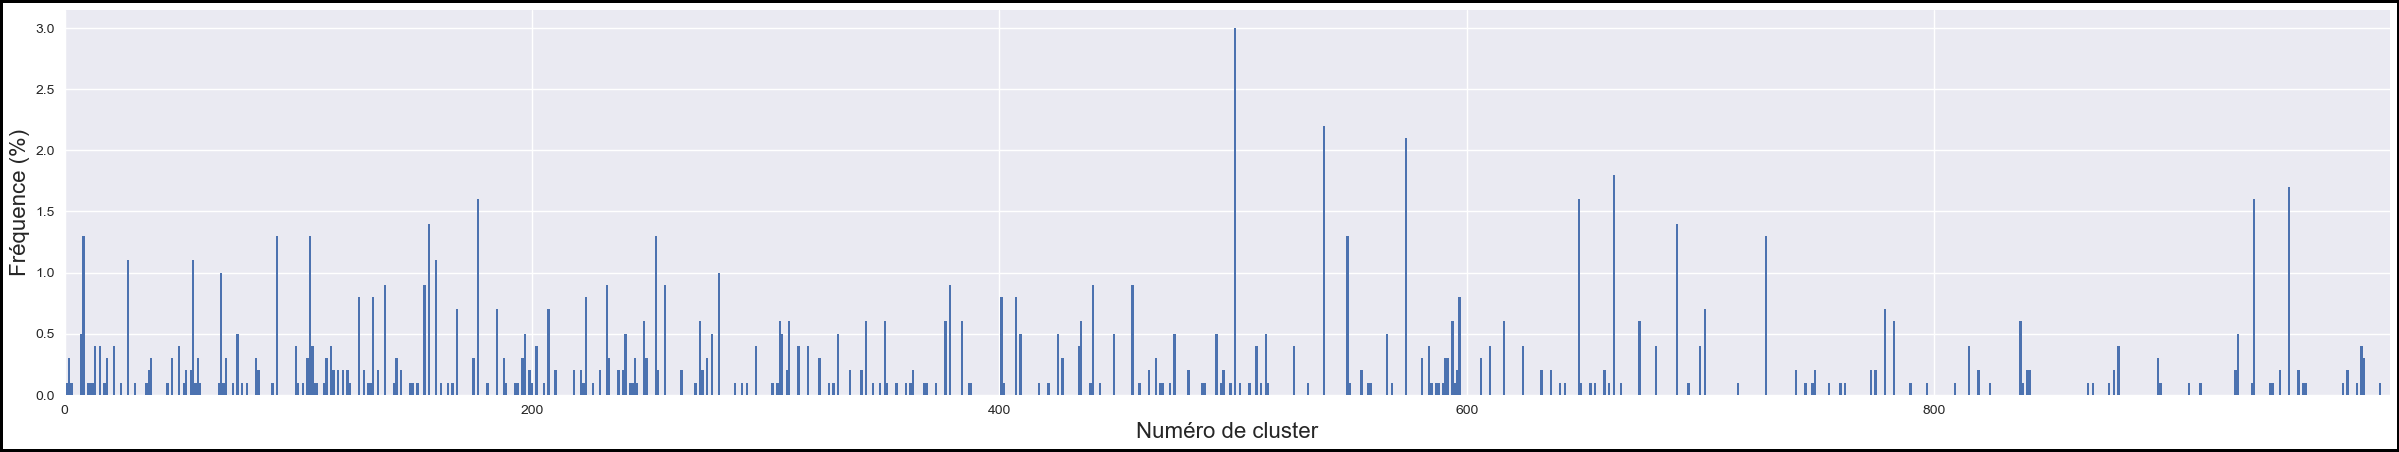

In [422]:
index_objet = 1
plt.figure(edgecolor='black', linewidth=4, figsize=(30, 5))
plt.bar(range(hist.shape[0]), 100*hist_vectors[index_objet], width=1)
plt.xlabel('Numéro de cluster', size=16)
plt.ylabel('Fréquence (%)', size=16)
plt.xlim(0, 995)
plt.show()

### Réductions de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [366]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
im_features_scaled = preprocessing.StandardScaler().fit_transform(im_features)   # données centrées réduites
feat_pca= pca.fit_transform(im_features_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

Dimensions dataset avant réduction PCA :  (1050, 995)
Dimensions dataset après réduction PCA :  (1050, 725)


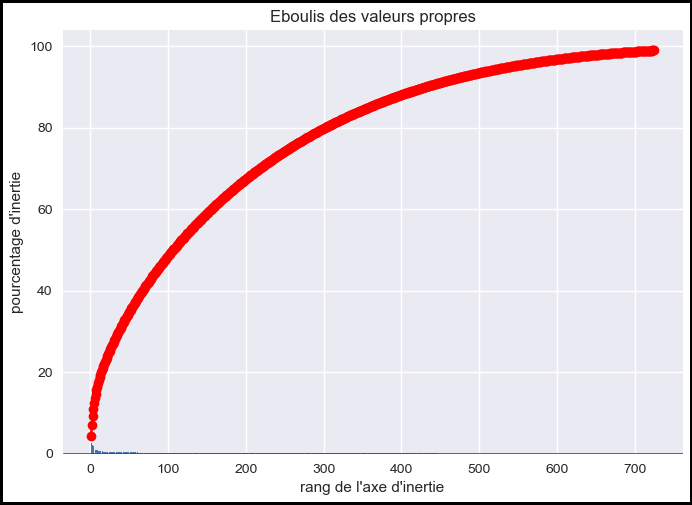

Une projection sur le premier plan factoriel ne semble pas pertinente, car ses 2 axes ne représentent que 6% de l'inertie.

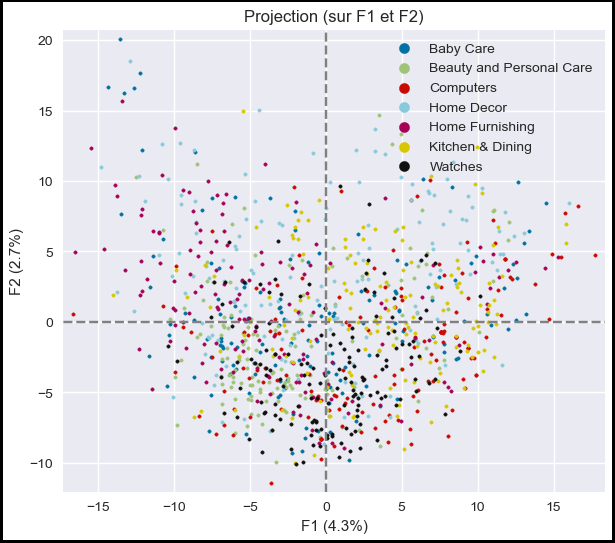

In [368]:
data_projected = pca.transform(im_features_scaled)
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
display_factorial_planes(data_projected, pca, [(0, 1)], size=6, illustrative_var=df_source['label'])
# display_factorial_planes(data_projected, pca, [(0, 1)], size=0.5, labels=[l for l in range(1050)])

Pas de cluster apparent après PCA.

#### Réduction de dimension t-SNE
* Réduction de dimension en 2 composantes t-SNE pour affichage en 2D des images

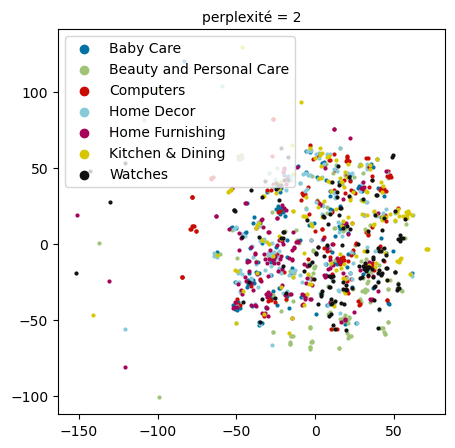

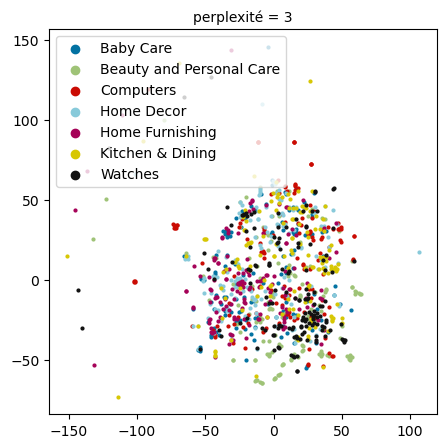

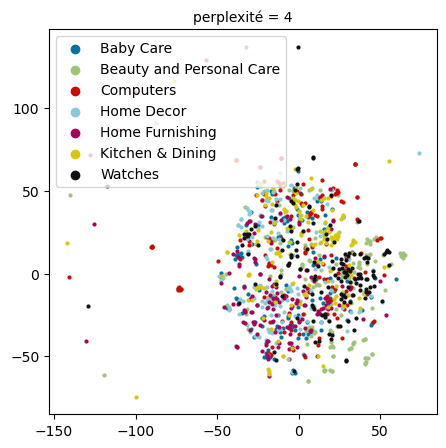

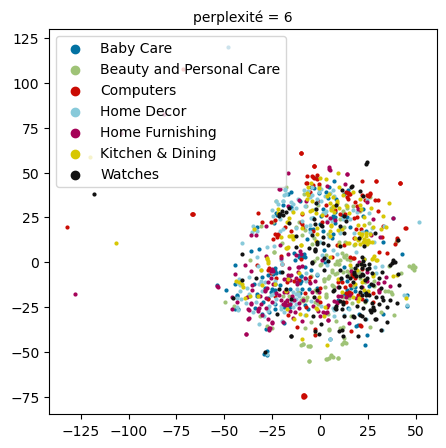

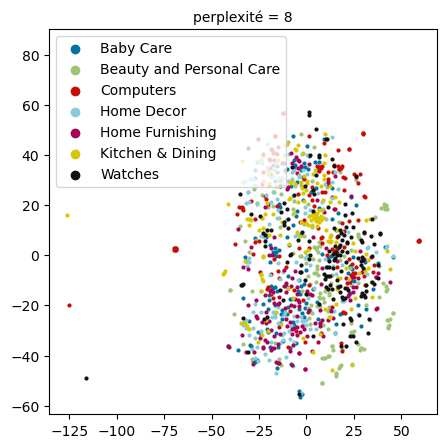

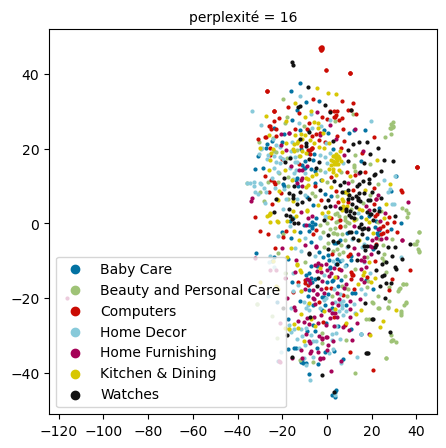

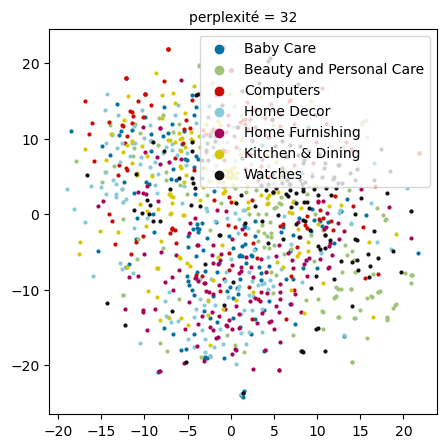

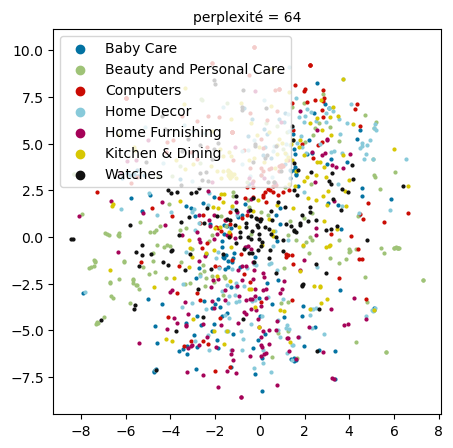

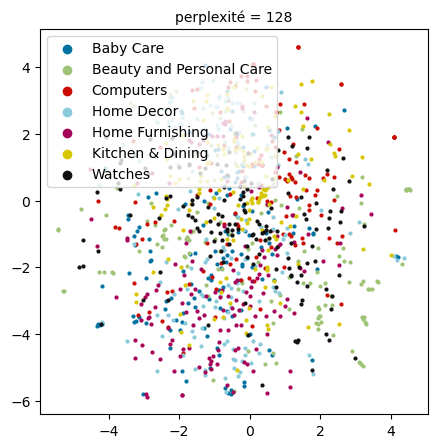

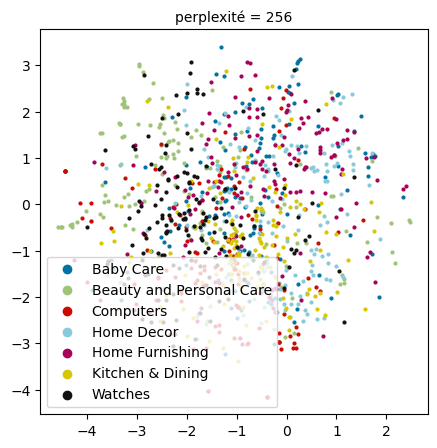

(1050, 2)

In [369]:
perplexities = [2, 3, 4, 6, 8, 16, 32, 64, 128, 256]
# perplexities = [30]

plt.style.use('default')
from matplotlib import rcParams
from cycler import cycler
rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

for perplexity in perplexities:
    plt.figure(figsize=(5, 5))
    tsne = manifold.TSNE(n_components=2, random_state=0, perplexity=perplexity)
    data_reduced_tsne = tsne.fit_transform(feat_pca)
    illustrative_var = np.array(df_source['label'])
    for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(data_reduced_tsne[selected, 0], data_reduced_tsne[selected, 1], s=4, label=value)
    plt.title('perplexité = ' + str(perplexity), fontsize=10)
    plt.legend(markerscale=3, frameon=True)
    plt.show()

### Clustering des images par k-means

#### Méthode du coude sur l'inertie pour déterminer le k optimum

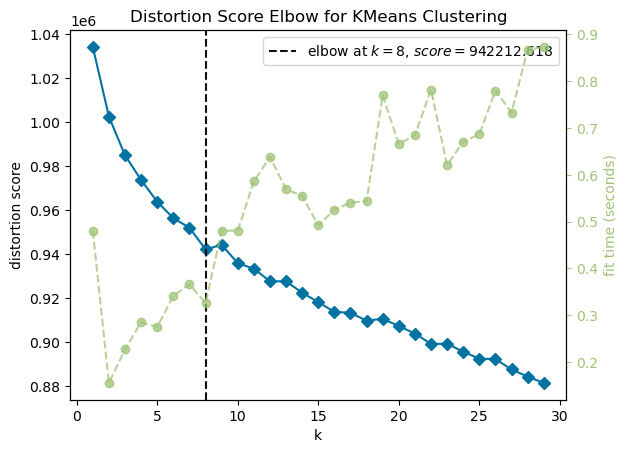

In [370]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 30))

visualizer.fit(feat_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

#### Score de silhouette pour déterminer le k optimum

In [371]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(feat_pca)
                for k in range(1, 15)]

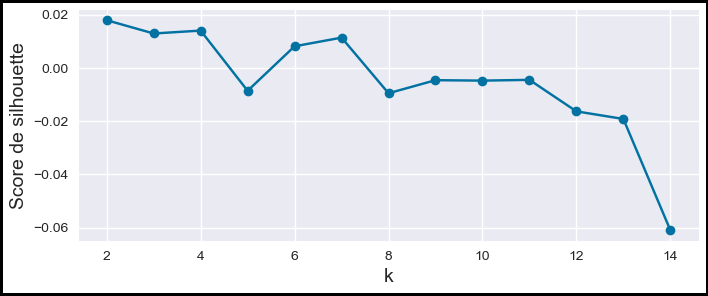

In [373]:
silhouette_scores = [silhouette_score(feat_pca, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

plt.style.use('seaborn')
plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Score de silhouette", fontsize=14)
plt.show()

#### Diagrammes de silhouette

In [377]:
def diagramme_silhouette(data_scaled, kmeans_per_k):
    """ Affichage du diagramme de silhouette
    Args : 
    - kmeans_per_k : liste des modélisations pour k=1 (oui, k=1) à k=k_max.
    - data_scaled : dataframe pandas converti, centré et normalisé.
    Returns :
    - tracés matplotlib (pour k=2 à k=k_max).
    """
    plt.style.use('seaborn')
    plt.figure(figsize=(11, 13), edgecolor='black', linewidth=4)
    
    silhouette_scores = [silhouette_score(data_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

    for k in range(2, 11):
        plt.subplot(3, 3, k - 1)

        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(data_scaled,
                                                     y_pred)

        padding = len(data_scaled) // 30
        pos = padding
        ticks = []

        # on trie les clusters du plus petit au plus grand
        taille_clusters = {}
        for i in range(k):
            taille_clusters[i] = len(silhouette_coefficients[y_pred == i])
        taille_clusters = {
            k: v
            for k, v in sorted(taille_clusters.items(),
                               key=lambda item: item[1])
        }
        i_color = 0
        for i in reversed(taille_clusters.keys()):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()
            color = mpl.cm.Spectral(i_color / (k - 1))
            i_color += 1
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)),
                              0,
                              coeffs,
                              facecolor=color,
                              edgecolor=color,
                              alpha=1)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(
            FixedFormatter(list(reversed(taille_clusters.keys()))))
        if k in (2, 5, 8):
            plt.ylabel("Cluster")
        plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        if k in (8, 9, 10):
            plt.xlabel("Coefficient de silhouette")
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=14)

    plt.show()

silhouette_scoress : [0.017902844351693294, 0.012915416056446697, 0.014007704625876903, -0.008600505308093472, 0.008106314972843705, 0.011365377148820785, -0.00953526971506689, -0.0046262731181612934, -0.004787784524806467, -0.004505330516292114, -0.016343158720167464, -0.019196688768379138, -0.06099984520488777]


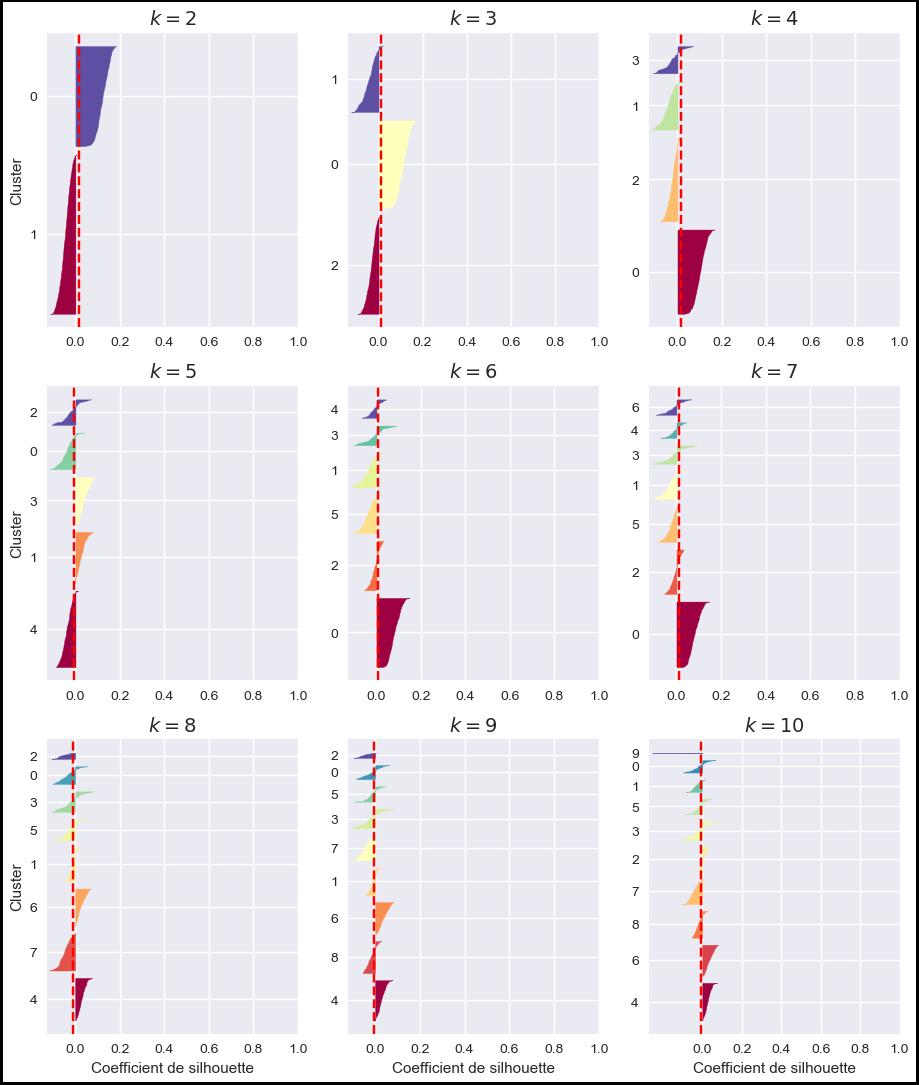

In [374]:
diagramme_silhouette(feat_pca, kmeans_per_k)

Les scores de silhouette sont faibles, mais ce n'est pas nécessairement mauvais dans la mesure où à dimension élevée (ici 995), les scores sont plus faibles.

#### Adjusted Rand Score

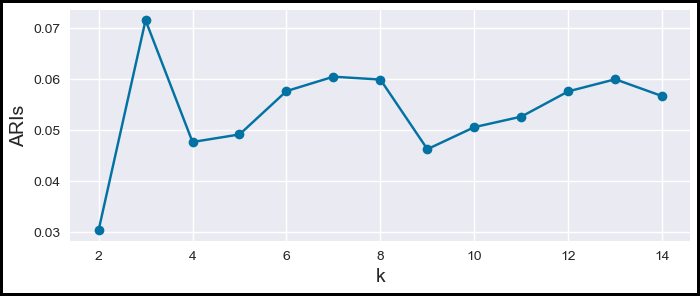

In [376]:
ARIs = [adjusted_rand_score(df_source['label'], model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

plt.style.use('seaborn')
plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
plt.plot(range(2, len(ARIs) + 2), ARIs, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("ARIs", fontsize=14)
plt.show()

### Affichage des images d'un cluster d'images (pour k-means avec k=10)

In [177]:
kmeans_k10 = KMeans(n_clusters=10, random_state=0).fit(feat_pca)
ser_labels = pd.Series(kmeans_k10.labels_)

nb de labels : 21


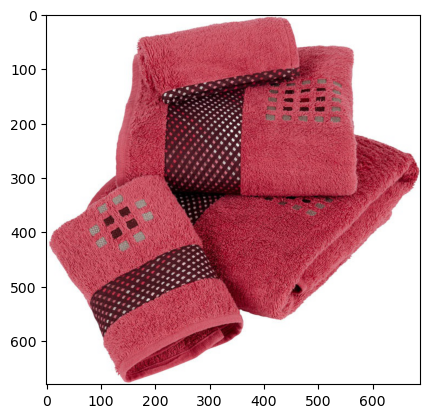

In [179]:
# affichage d'objets de label  : 
# label 4 : bcp de mugs et de montres
# label 6 : bcp de kitch indien
# label 8 : pas de catégorie surreprésentée a priori
ser_bool = (ser_labels == 7)
labels_x = list(ser_labels[ser_bool].index)  
print("nb de labels :", len(labels_x))
random.shuffle(labels_x)
for index in labels_x[:1]:
    print_df_line(index, image_only=True)

Le clustering sur la base de 985 features issues de descripteurs SIFT n'est pas concluant.

## Variation du nb de clusters de descripteurs

### Pour comparer différentes silhouettes de partitionnement

In [155]:
def clustering_descripteurs_et_silhouettes_pipeline(k):
    print("Nombre de clusters de descripteurs : ", k)

    # Clustering descripteurs
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
    kmeans.fit(sift_keypoints_all)
    
    # Creation of a matrix of histograms
    hist_vectors = []
    for i, image_desc in enumerate(sift_keypoints_by_img):
        hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
        hist_vectors.append(hist)  # hist is the feature vector
    im_features = np.asarray(hist_vectors)
    
    #PCA
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    im_features_scaled = preprocessing.StandardScaler().fit_transform(im_features)   # données centrées réduites
    feat_pca= pca.fit_transform(im_features_scaled)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    #Silhouettes
    kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(feat_pca)
                for k in range(1, 15)]
    silhouette_scores = [silhouette_score(feat_pca, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1
    plt.style.use('seaborn')
    plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
    plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, "bo-")
    plt.xlabel("k", fontsize=14)
    plt.ylabel("Score de silhouette", fontsize=14)
    plt.show()
    diagramme_silhouette(feat_pca, kmeans_per_k)

In [157]:
# for k in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
#     clustering_descripteurs_et_silhouettes_pipeline(k)

Le résultat ci-dessus n'est pas sauvegardé car les images prennent trop de place en mémoire de stockage.

### Pour comparer les ARIs

In [381]:
def clustering_descripteurs_et_ARIs_pipeline(k):
    print("Nombre de clusters de descripteurs : ", k)

    # Clustering descripteurs
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
    kmeans.fit(sift_keypoints_all)
    
    # Creation of a matrix of histograms
    hist_vectors = []
    for i, image_desc in enumerate(sift_keypoints_by_img):
        hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
        hist_vectors.append(hist)  # hist is the feature vector
    im_features = np.asarray(hist_vectors)
    
    #PCA
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    im_features_scaled = preprocessing.StandardScaler().fit_transform(im_features)   # données centrées réduites
    feat_pca= pca.fit_transform(im_features_scaled)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    #ARIs
    kmeans_per_k = [KMeans(n_clusters=n, random_state=0).fit(feat_pca)
                for n in range(1, 15)]
    ARIs = [adjusted_rand_score(df_source['label'], model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1
    plt.style.use('seaborn')
    plt.figure(figsize=(5, 2), edgecolor='black', linewidth=4)
    plt.plot(range(2, len(ARIs) + 2), ARIs, "bo-")
    plt.title(f"{k} clusters de descripteurs", fontsize=14)
    plt.xlabel("nb clusters d'images", fontsize=12)
    plt.ylabel("ARIs", fontsize=12)
    plt.show()

Nombre de clusters de descripteurs :  2
Dimensions dataset avant réduction PCA :  (1050, 2)
Dimensions dataset après réduction PCA :  (1050, 1)


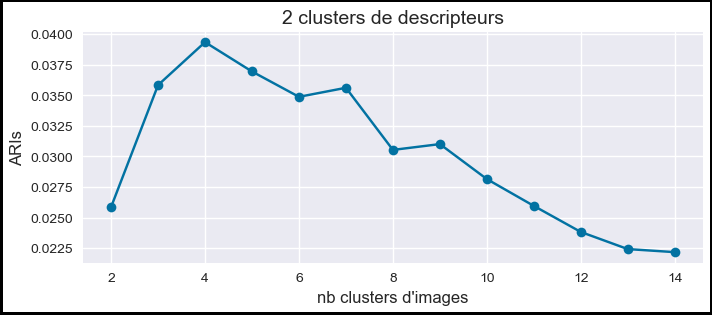

Nombre de clusters de descripteurs :  4
Dimensions dataset avant réduction PCA :  (1050, 4)
Dimensions dataset après réduction PCA :  (1050, 3)


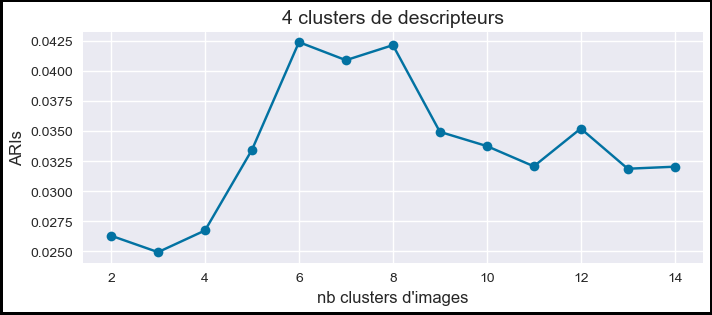

Nombre de clusters de descripteurs :  8
Dimensions dataset avant réduction PCA :  (1050, 8)
Dimensions dataset après réduction PCA :  (1050, 6)


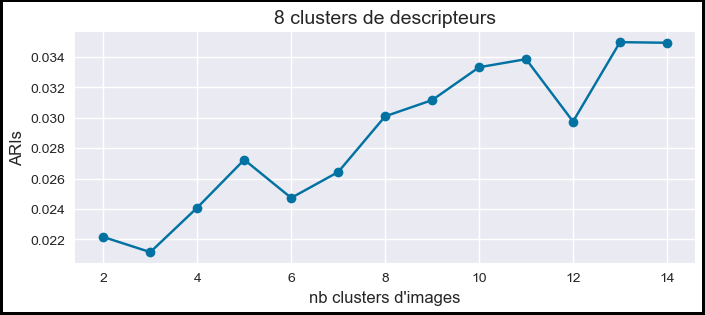

Nombre de clusters de descripteurs :  16
Dimensions dataset avant réduction PCA :  (1050, 16)
Dimensions dataset après réduction PCA :  (1050, 13)


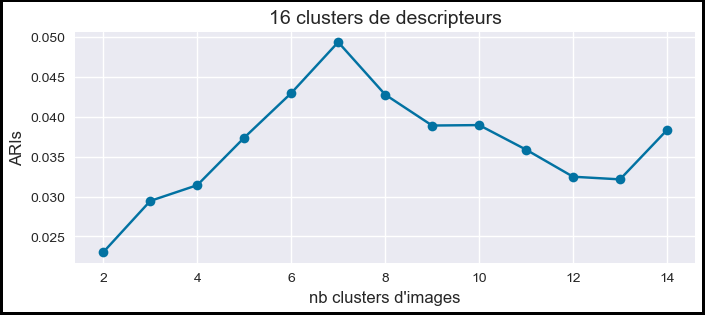

Nombre de clusters de descripteurs :  32
Dimensions dataset avant réduction PCA :  (1050, 32)
Dimensions dataset après réduction PCA :  (1050, 27)


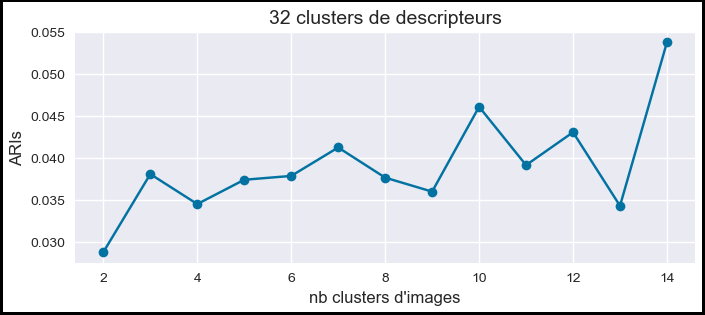

Nombre de clusters de descripteurs :  64
Dimensions dataset avant réduction PCA :  (1050, 64)
Dimensions dataset après réduction PCA :  (1050, 56)


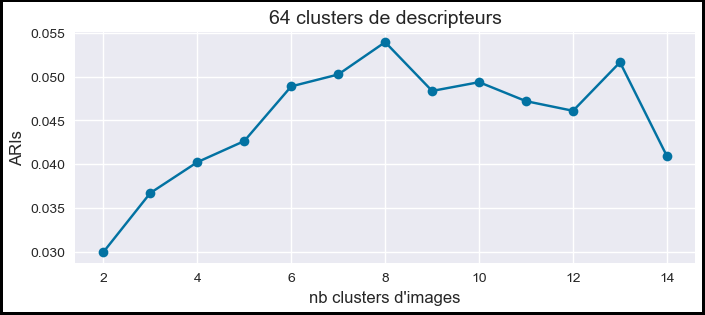

Nombre de clusters de descripteurs :  128
Dimensions dataset avant réduction PCA :  (1050, 128)
Dimensions dataset après réduction PCA :  (1050, 113)


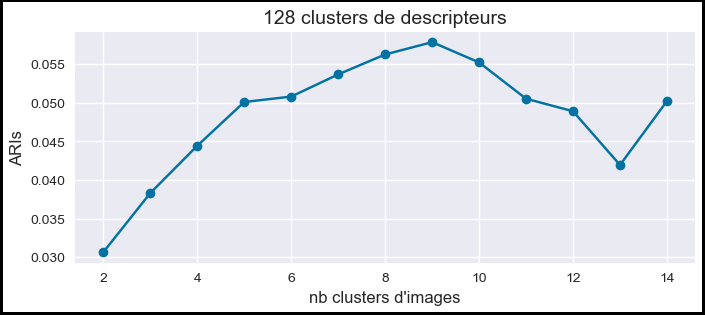

Nombre de clusters de descripteurs :  256
Dimensions dataset avant réduction PCA :  (1050, 256)
Dimensions dataset après réduction PCA :  (1050, 225)


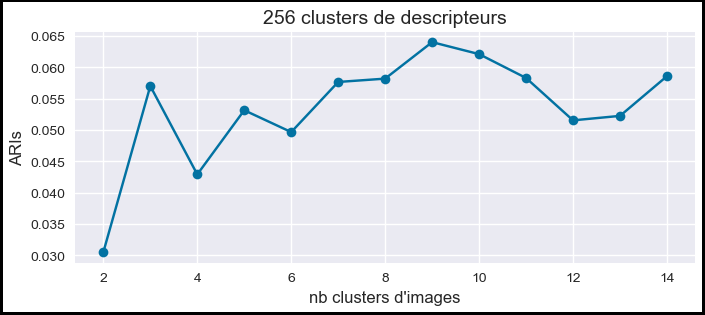

Nombre de clusters de descripteurs :  512
Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 430)


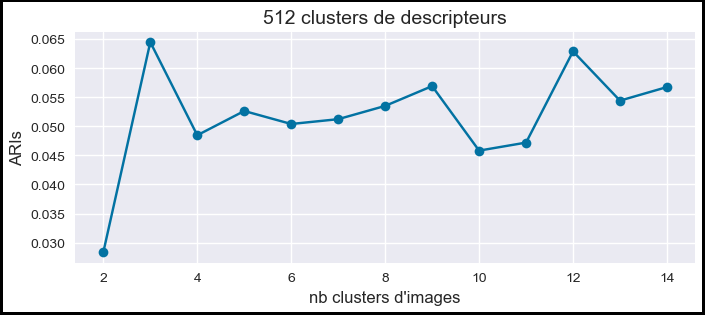

Nombre de clusters de descripteurs :  1024
Dimensions dataset avant réduction PCA :  (1050, 1024)
Dimensions dataset après réduction PCA :  (1050, 714)


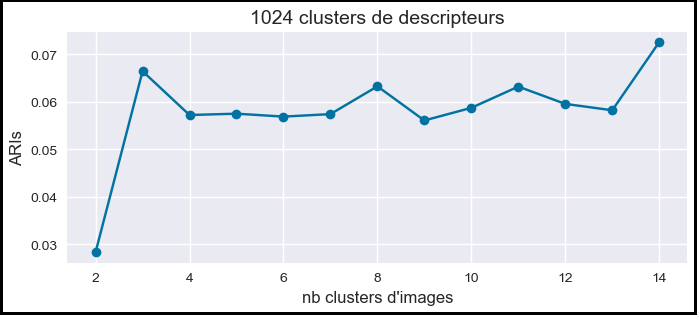

Nombre de clusters de descripteurs :  2048
Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 911)


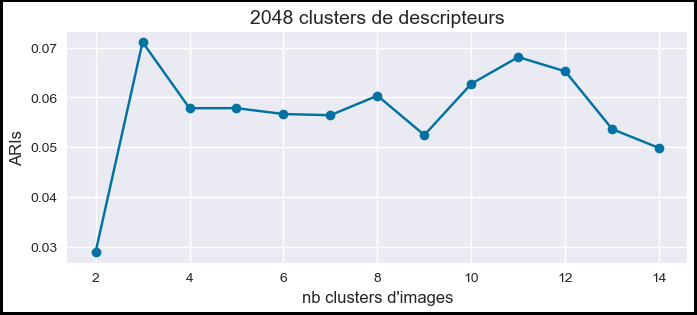

In [382]:
for k in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
    clustering_descripteurs_et_ARIs_pipeline(k)

Le clustering sur la base de features issues de descripteurs SIFT n'est pas concluant.

### Pour comparer les ARIs

In [381]:
def clustering_descripteurs_et_ARIs_pipeline(k):
    print("Nombre de clusters de descripteurs : ", k)

    # Clustering descripteurs
    kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
    kmeans.fit(sift_keypoints_all)
    
    # Creation of a matrix of histograms
    hist_vectors = []
    for i, image_desc in enumerate(sift_keypoints_by_img):
        hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
        hist_vectors.append(hist)  # hist is the feature vector
    im_features = np.asarray(hist_vectors)
    
    #PCA
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=0.99)
    im_features_scaled = preprocessing.StandardScaler().fit_transform(im_features)   # données centrées réduites
    feat_pca= pca.fit_transform(im_features_scaled)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    #ARIs
    kmeans_per_k = [KMeans(n_clusters=n, random_state=0).fit(feat_pca)
                for n in range(1, 15)]
    ARIs = [adjusted_rand_score(df_source['label'], model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1
    plt.style.use('seaborn')
    plt.figure(figsize=(5, 2), edgecolor='black', linewidth=4)
    plt.plot(range(2, len(ARIs) + 2), ARIs, "bo-")
    plt.title(f"{k} clusters de descripteurs", fontsize=14)
    plt.xlabel("nb clusters d'images", fontsize=12)
    plt.ylabel("ARIs", fontsize=12)
    plt.show()

Nombre de clusters de descripteurs :  2
Dimensions dataset avant réduction PCA :  (1050, 2)
Dimensions dataset après réduction PCA :  (1050, 1)


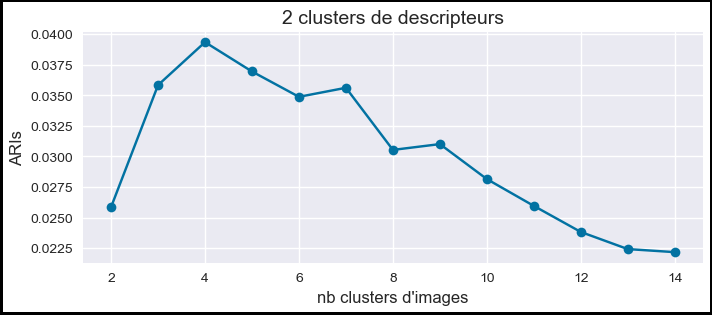

Nombre de clusters de descripteurs :  4
Dimensions dataset avant réduction PCA :  (1050, 4)
Dimensions dataset après réduction PCA :  (1050, 3)


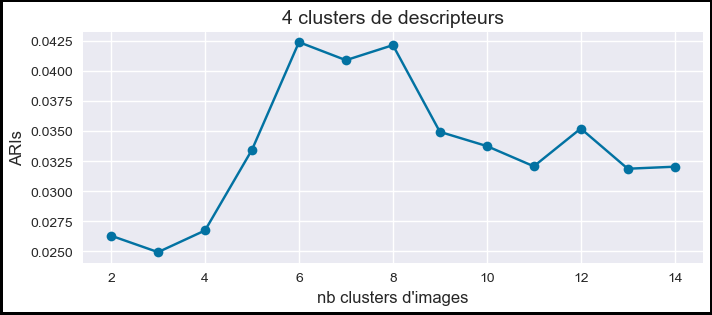

Nombre de clusters de descripteurs :  8
Dimensions dataset avant réduction PCA :  (1050, 8)
Dimensions dataset après réduction PCA :  (1050, 6)


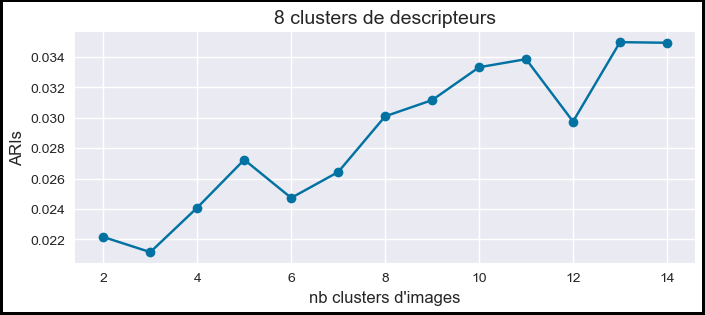

Nombre de clusters de descripteurs :  16
Dimensions dataset avant réduction PCA :  (1050, 16)
Dimensions dataset après réduction PCA :  (1050, 13)


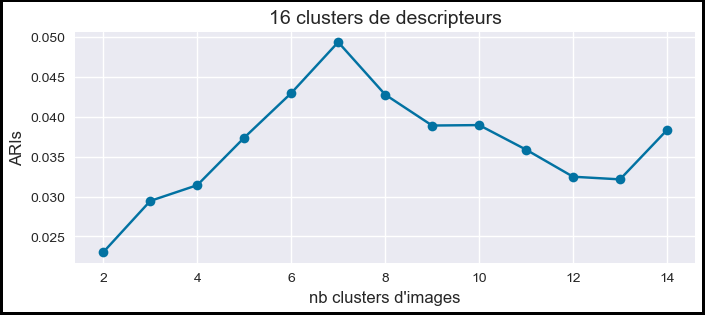

Nombre de clusters de descripteurs :  32
Dimensions dataset avant réduction PCA :  (1050, 32)
Dimensions dataset après réduction PCA :  (1050, 27)


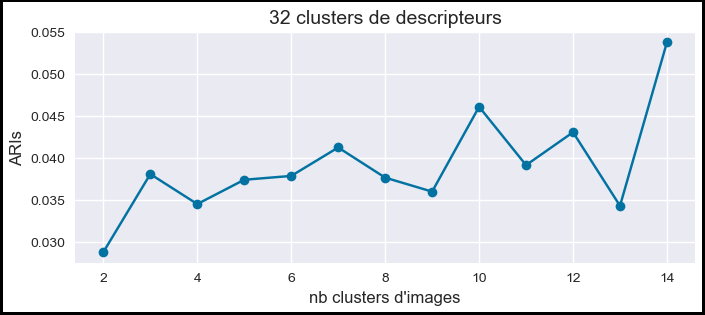

Nombre de clusters de descripteurs :  64
Dimensions dataset avant réduction PCA :  (1050, 64)
Dimensions dataset après réduction PCA :  (1050, 56)


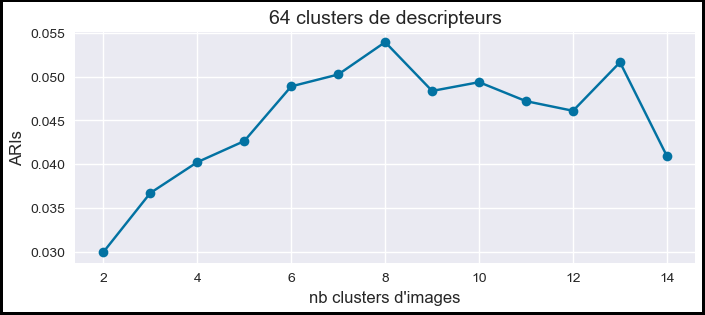

Nombre de clusters de descripteurs :  128
Dimensions dataset avant réduction PCA :  (1050, 128)
Dimensions dataset après réduction PCA :  (1050, 113)


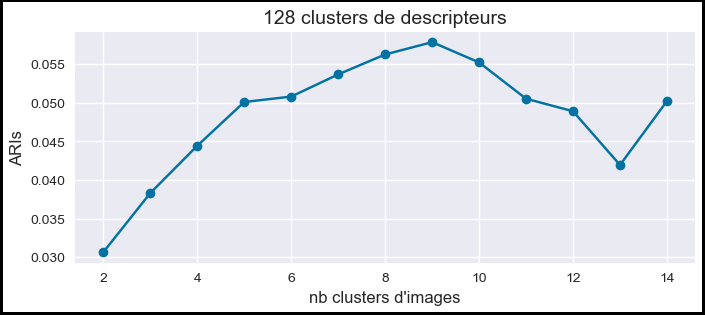

Nombre de clusters de descripteurs :  256
Dimensions dataset avant réduction PCA :  (1050, 256)
Dimensions dataset après réduction PCA :  (1050, 225)


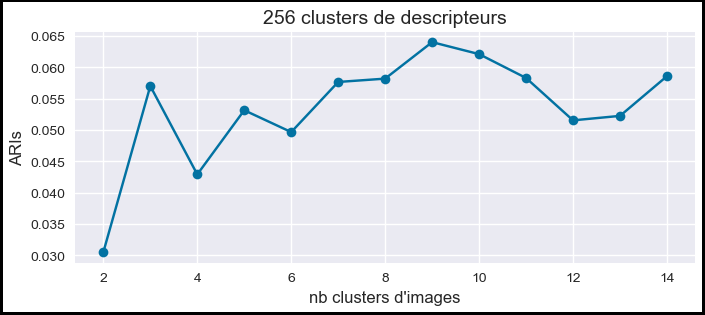

Nombre de clusters de descripteurs :  512
Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 430)


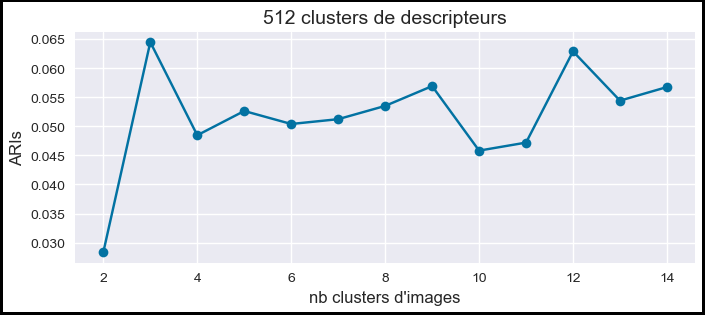

Nombre de clusters de descripteurs :  1024
Dimensions dataset avant réduction PCA :  (1050, 1024)
Dimensions dataset après réduction PCA :  (1050, 714)


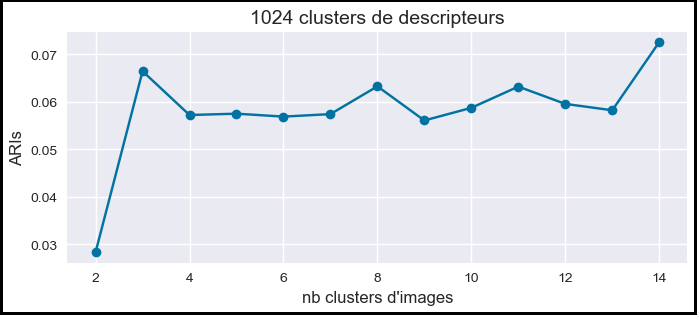

Nombre de clusters de descripteurs :  2048
Dimensions dataset avant réduction PCA :  (1050, 2048)
Dimensions dataset après réduction PCA :  (1050, 911)


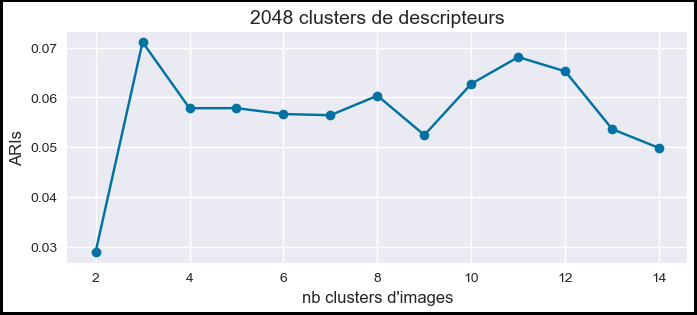

In [382]:
for k in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
    clustering_descripteurs_et_ARIs_pipeline(k)

Le clustering sur la base de features issues de descripteurs SIFT n'est pas concluant.

# ORB

## Descripteurs d'une image

In [451]:
def descripteurs_orb(index, plot=True, dimension=True):
    """Retourne les descripteurs ORB d'une photo.
    Args : 
    - index : index de la ligne de df_source.
    - plot : booléen pour tracer ou non la photo avec ses descripteurs.
    - dimension : booléen pour imprimer la dimension des descripteurs.
    Returns :
    - array numpy (descripteur ORB) de 32 colonnes et "descripteurs" lignes.
    """
    image = cv2.imread(PATH + df_source['image'][index], 0)  # convert in grey
    image = cv2.equalizeHist(image)  # equalize image histogram
    orb = cv2.ORB_create(nfeatures=1000000)
    kp, des = orb.detectAndCompute(image, None)
    if plot:
        plt.style.use('default')
        plt.figure(figsize=(40, 40), edgecolor='black', linewidth=4)
        img = cv2.drawKeypoints(image, kp, image)
        plt.imshow(img)
        plt.show()
    if dimension:
        print("Dimension descripteurs : ", des.shape)
    return des

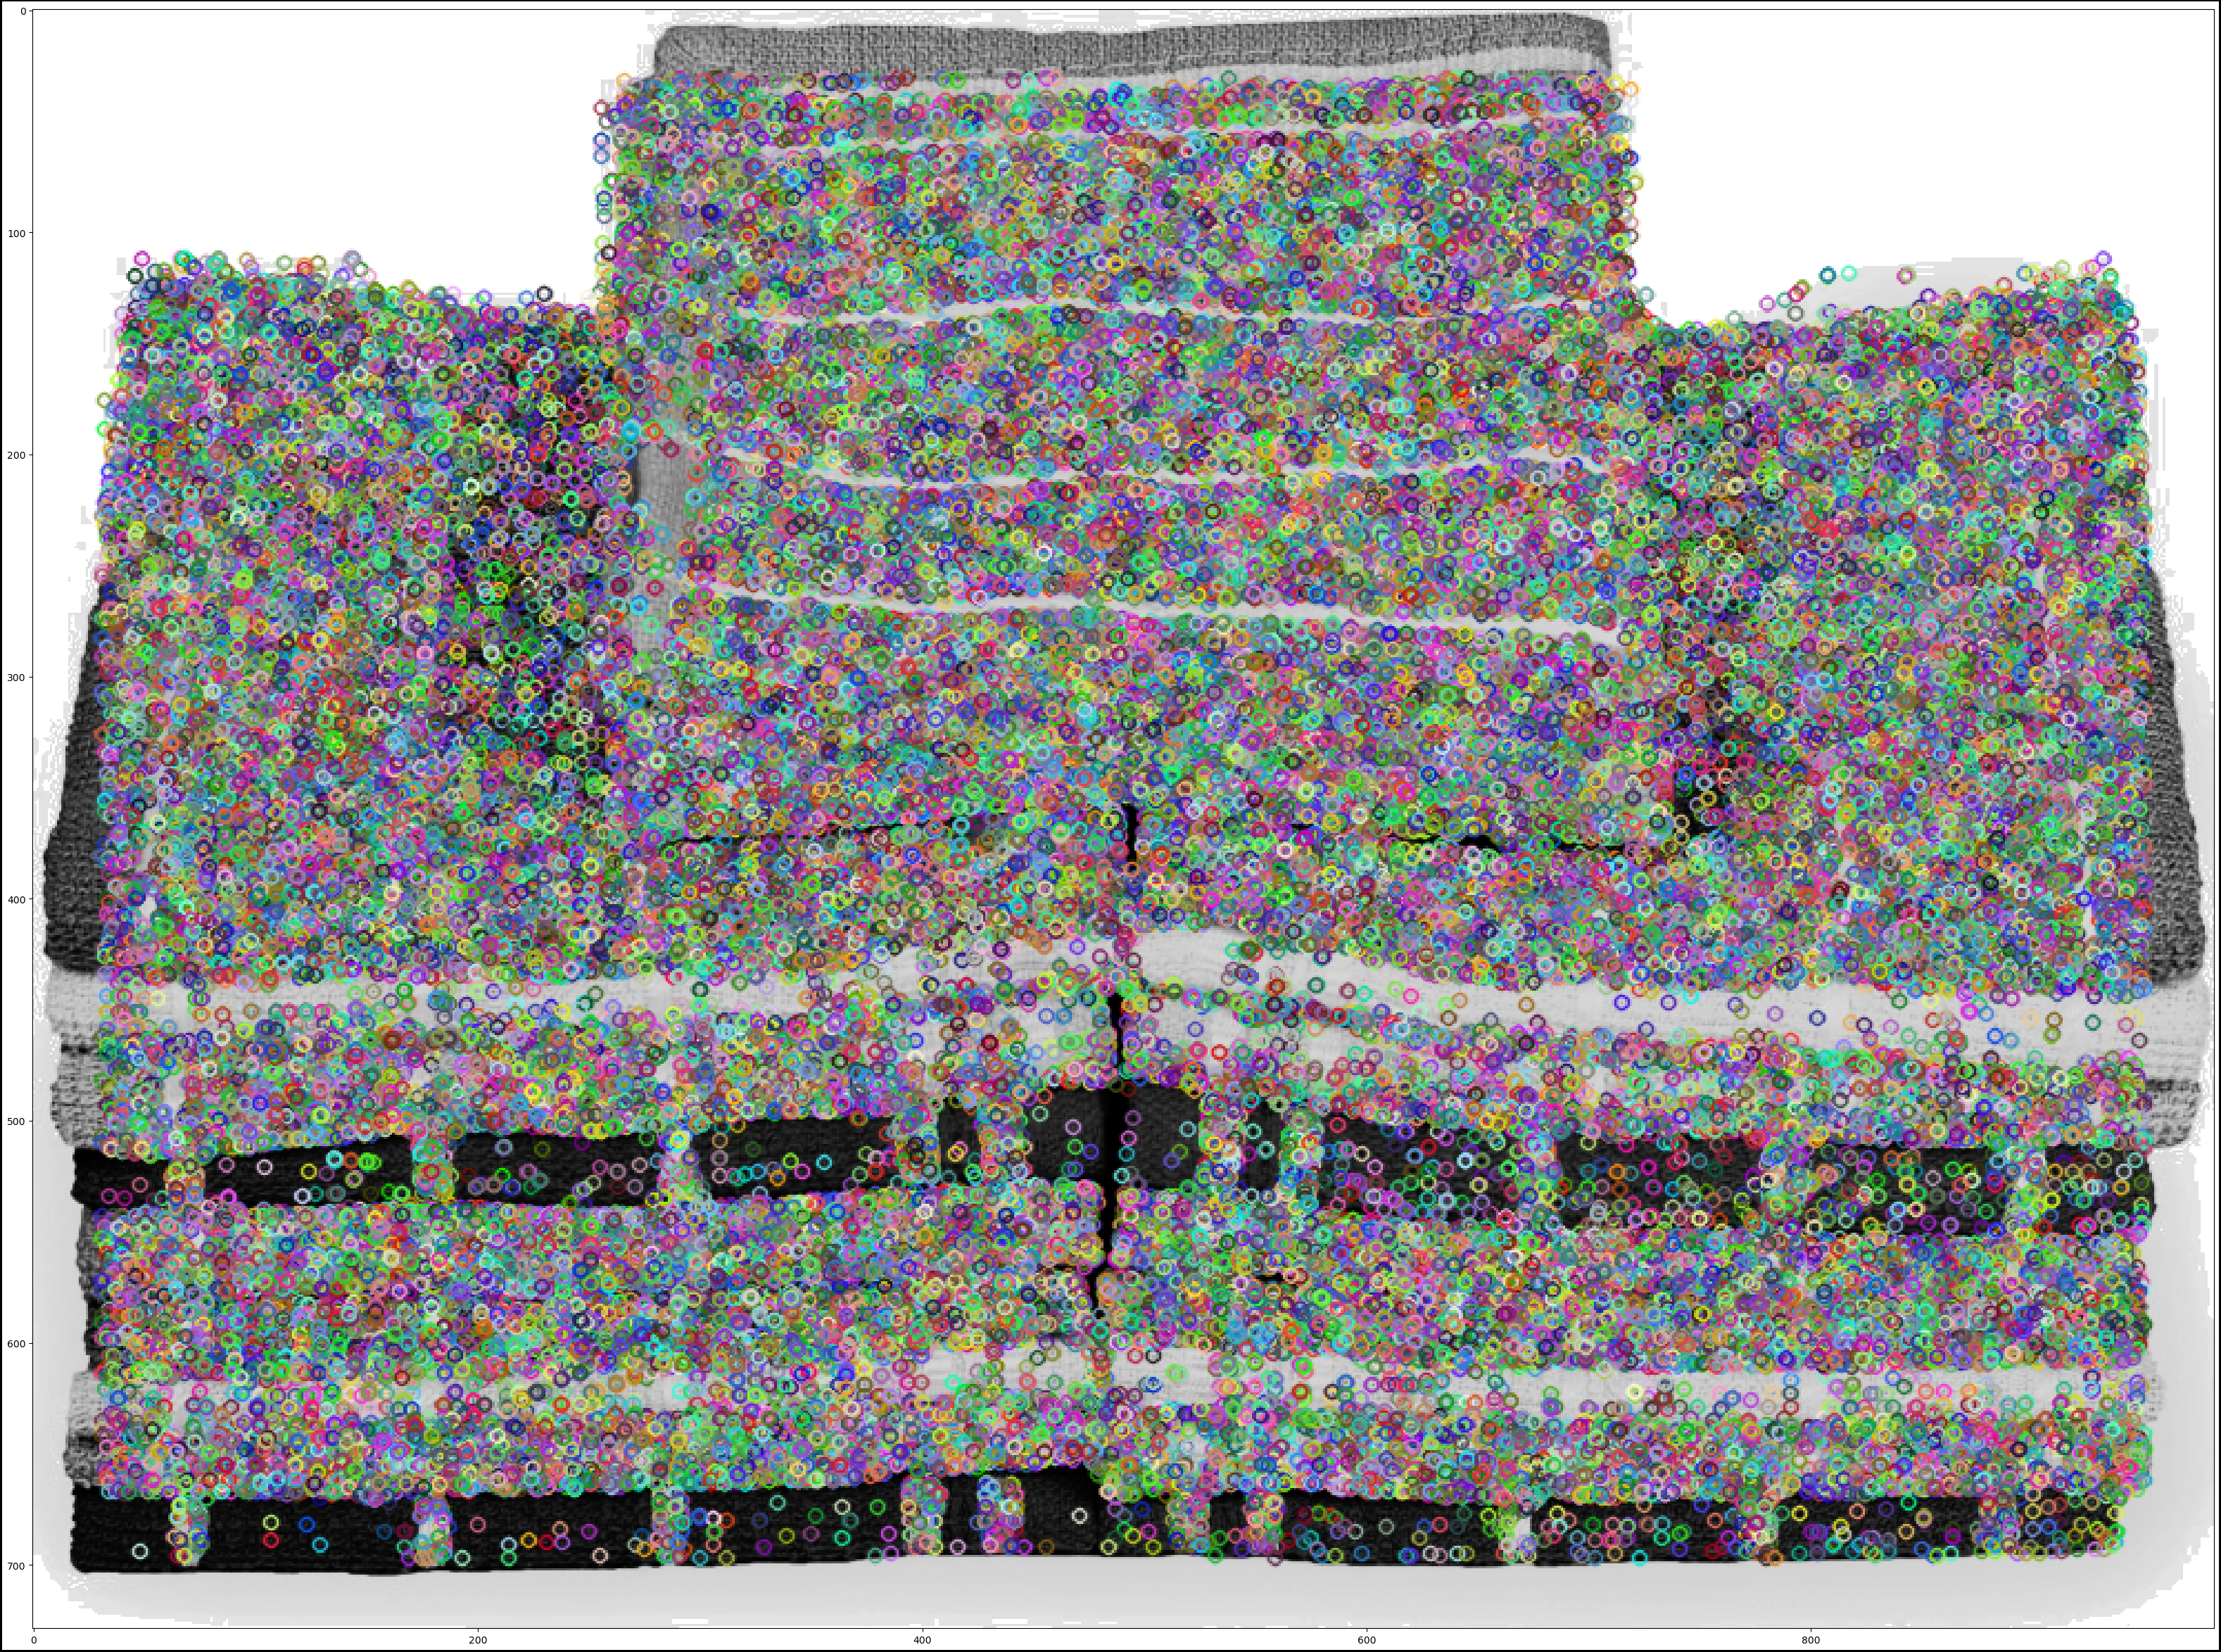

Dimension descripteurs :  (62959, 32)


array([[112, 195, 104, ..., 154, 252, 108],
       [252,  72, 191, ..., 187, 116,  33],
       [148,  72, 254, ...,  59,  37,  43],
       ...,
       [  0,  73,  30, ..., 155, 169, 168],
       [  1, 162, 209, ...,   8,  75, 128],
       [ 66, 169,  26, ...,  14,  15, 206]], dtype=uint8)

In [453]:
# test unitaire
descripteurs_orb(2)

## Créations des descripteurs de chaque image (1030000 descripteurs, ~1000 par image)
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("orb_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("orb_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs
* Le calcul des descripteurs sur notre dataset est 6 fois plus rapide avec ORB que SIFT

In [496]:
# identification of key points and associated descriptors
orb_keypoints = []
orb = cv2.ORB_create(nfeatures=1000)   # on se limite à 1000, sur ce dataset, il est fréquent de récupérer des descripteurs à 100000 lignes

for index in range(len(df_source)) :
    if index%10 == 0 : print(index, "", end='')
    image = cv2.imread(nom_fichier_photo(index),0) # ouverture fichier image et conversion en niveaux de gris
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 

In [455]:
# Sauvegarde des descripteurs calculés (pickle)
pickle.dump(orb_keypoints, open('orb_keypoints.pkl', 'wb'))

In [509]:
# Chargement des descripteurs calculés (pickle)
orb_keypoints = pickle.load(open('orb_keypoints.pkl', 'rb'))
len(orb_keypoints)

1050

In [510]:
orb_keypoints_by_img = np.asarray(orb_keypoints, dtype=object)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

Nombre de descripteurs :  (1032942, 32)


## Utilisation de 1016 clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [511]:
k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters : ", k)

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

Nombre de clusters :  1016


MiniBatchKMeans(init_size=3048, n_clusters=1016, random_state=0)

In [500]:
pickle.dump(kmeans, open('kmeans_2923clusters_10000features_ORB.pkl', 'wb'))

### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [512]:
# Creation of a matrix of histograms
hist_vectors_orb = []

for i, image_desc in enumerate(orb_keypoints_by_img):
    if i % 10 == 0:
        print(i, "", end='')
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors_orb.append(hist)  # hist is the feature vector

im_features = np.asarray(hist_vectors_orb)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 

### Affichage d'histogramme

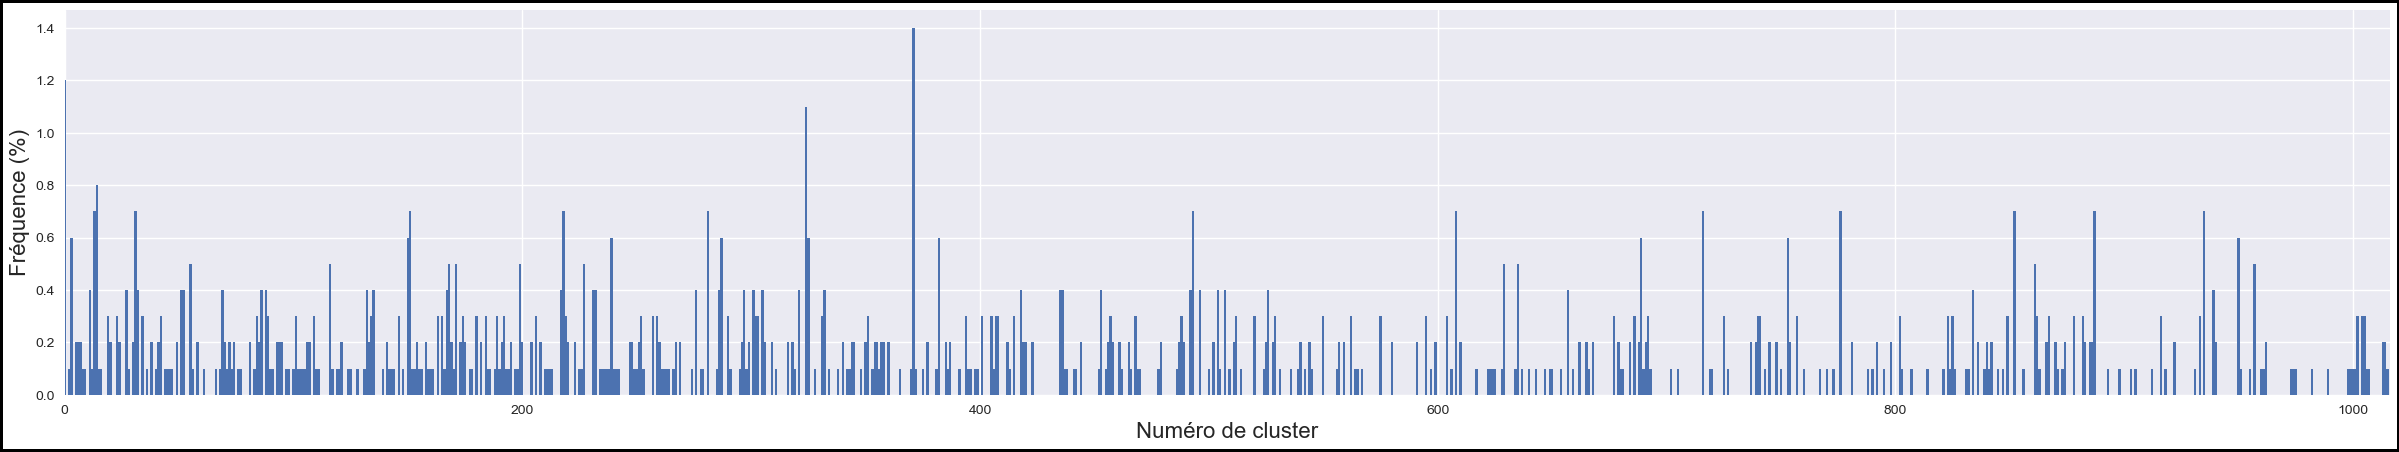

In [513]:
index_objet = 1
plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4, figsize=(30, 5))
plt.bar(range(hist.shape[0]), 100*hist_vectors_orb[index_objet], width=1)
plt.xlabel('Numéro de cluster', size=16)
plt.ylabel('Fréquence (%)', size=16)
plt.xlim(0, len(hist_vectors_orb[0]))
plt.show()

### Réductions de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

Dimensions dataset avant réduction PCA :  (1050, 1016)
Dimensions dataset après réduction PCA :  (1050, 742)


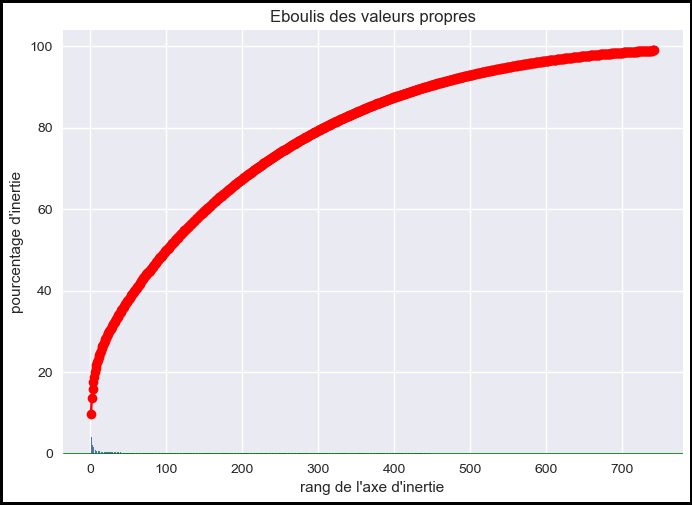

In [514]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
im_features_scaled = preprocessing.StandardScaler().fit_transform(im_features)   # données centrées réduites
feat_pca= pca.fit_transform(im_features_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

Une projection sur le premier plan factoriel ne semble pas pertinente, car ses 2 axes ne représentent qu'une faible part de l'inertie.

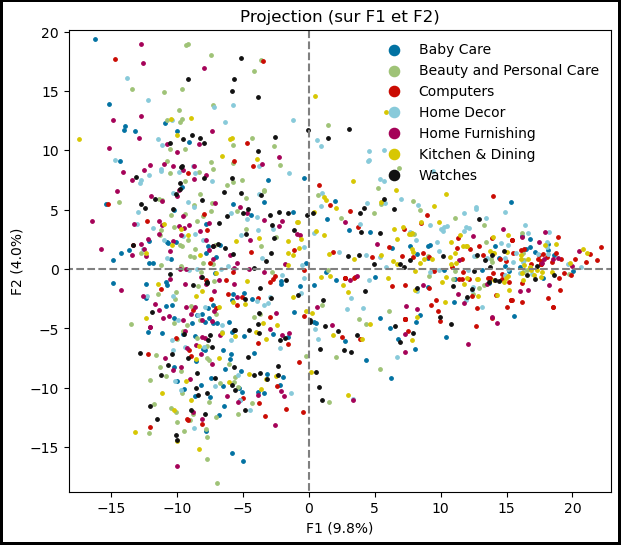

In [515]:
data_projected = pca.transform(im_features_scaled)
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
display_factorial_planes(data_projected, pca, [(0, 1)], size=6, illustrative_var=df_source['label'])

Pas de cluster apparent après PCA.

#### Réduction de dimension t-SNE
* Réduction de dimension en 2 composantes t-SNE pour affichage en 2D des images

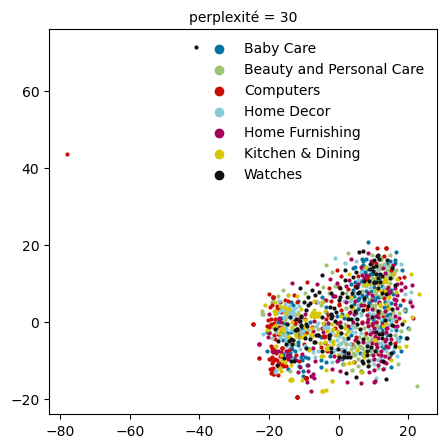

In [516]:
# perplexities = [2, 3, 4, 6, 8, 16, 32, 64, 128, 256]
perplexities = [30]

plt.style.use('default')
rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

for perplexity in perplexities:
    plt.figure(figsize=(5, 5))
    tsne = manifold.TSNE(n_components=2, random_state=0, perplexity=perplexity)
    data_reduced_tsne = tsne.fit_transform(feat_pca)
    illustrative_var = np.array(df_source['label'])
    for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(data_reduced_tsne[selected, 0], data_reduced_tsne[selected, 1], s=4, label=value)
    plt.title('perplexité = ' + str(perplexity), fontsize=10)
    plt.legend(markerscale=3, frameon=False)
    plt.show()

### Clustering des images par k-means

#### Méthode du coude sur l'inertie pour déterminer le k optimum

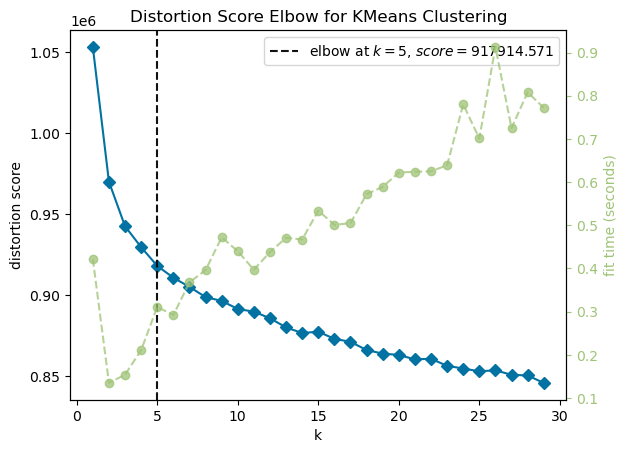

In [487]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 30))
visualizer.fit(feat_pca)    
visualizer.show();        

#### Score de silhouette pour déterminer le k optimum

In [517]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=0).fit(feat_pca)
                for k in range(1, 15)]

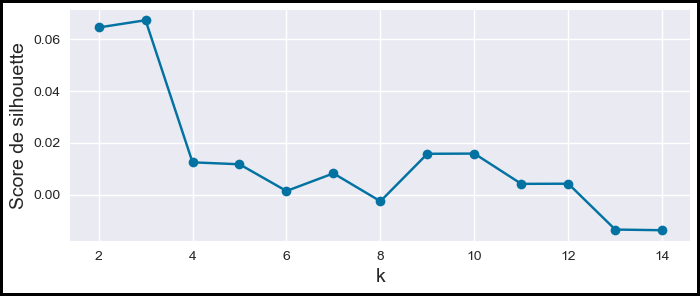

In [518]:
silhouette_scores = [silhouette_score(feat_pca, model.labels_)
                     for model in kmeans_per_k[1:]]  # k doit être > 1

plt.style.use('seaborn')
plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Score de silhouette", fontsize=14)
plt.show()

#### Diagrammes de silhouette

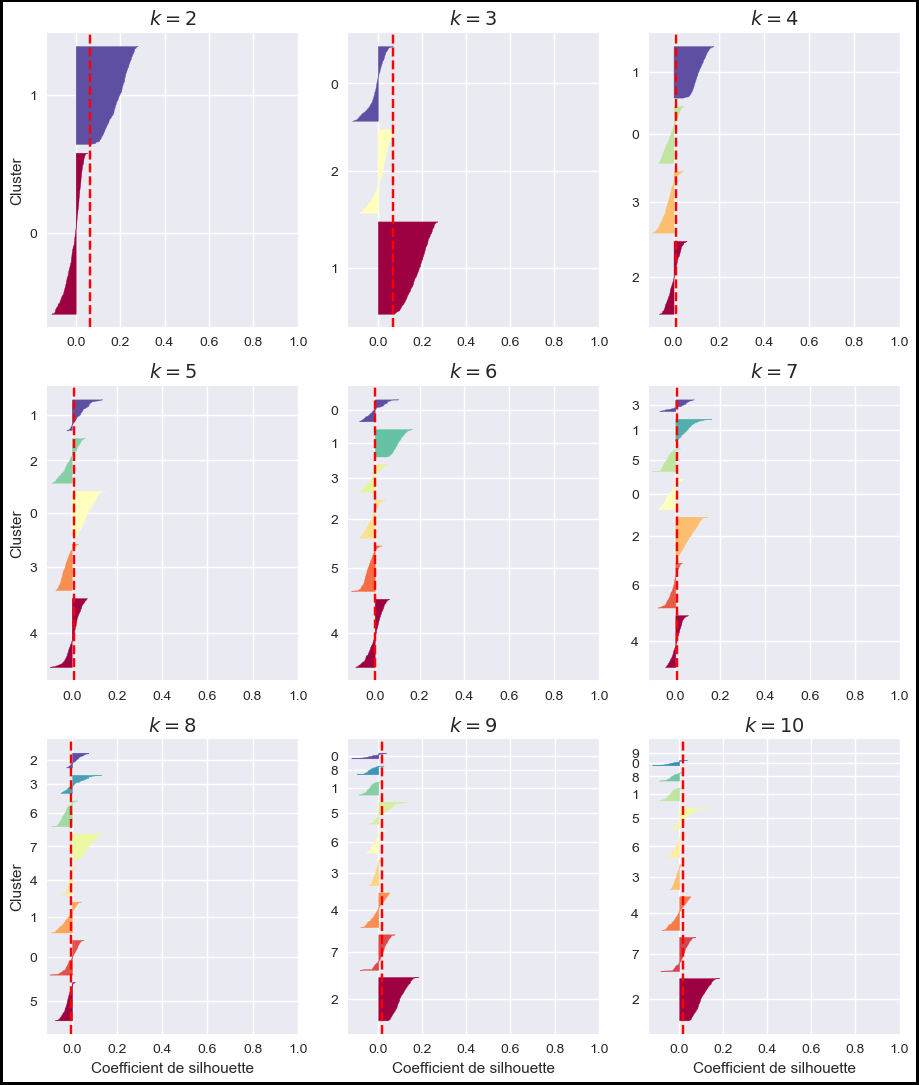

In [490]:
diagramme_silhouette(feat_pca, kmeans_per_k)

Les scores de silhouette sont faibles, mais ce n'est pas nécessairement mauvais dans la mesure où à dimension élevée, les scores sont plus faibles.

#### Adjusted Rand Score pour les 7 catégories labellisées

In [495]:
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))
print(" avec : orb = cv2.ORB_create(nfeatures=1000)")

ARI : 0.039581560566572464
 avec : orb = cv2.ORB_create(nfeatures=1000)


In [508]:
# Résultat obtenu en augmentant nfeatures à 10000 lors de la création de l'objet   orb = cv2.ORB_create(nfeatures=10000)
model = KMeans(n_clusters=7, random_state=0, n_init=200).fit(feat_pca)
print("ARI :", adjusted_rand_score(df_source['label'], model.labels_))
print(" avec : orb = cv2.ORB_create(nfeatures=10000)")

ARI : 0.0388716666300218
 avec : orb = cv2.ORB_create(nfeatures=10000)
